## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [20]:
# 檢查Dataset 的描述與資訊
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [27]:
from keras.layers import Dropout
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.regularizers import l1_l2
import os



In [28]:
batch_size = 32
num_classes = 10
epochs = 20
data_augmentation = True
num_predictions = 20

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [29]:


# INPUT = x_train.shape[1:]
def build_mlp_CNN(input_shape, output_units=10,ratio=0.01,ratio2=0.01,drop_r=0.2,do_NB = True):
    model = Sequential()
    #   第二步：構建網絡層
    if do_NB == True:
        
        model.add(Conv2D(32, (3, 3), padding='same',
                         input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv2D(32, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(drop_r))

        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        model.add(Conv2D(64, (3, 3)))
       
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(drop_r))
        model.add(BatchNormalization())

        model.add(Flatten())
        model.add(Dense(units = 512,activation="relu",kernel_regularizer=l1_l2(ratio,ratio2)))
        model.add(Activation('relu'))
        model.add(Dropout(drop_r))
        model.add(BatchNormalization())
        
        model.add(Dense(output_units)) # 輸出結果是10個類別，所以維度是10   
        model.add(Activation('softmax')) # 最後一層用softmax作為激活函數
    else:
        model.add(Conv2D(32, (3, 3), padding='same',
                         input_shape=input_shape))
        model.add(Activation('relu'))
        model.add(Conv2D(32, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(units = 512,activation="relu",kernel_regularizer=l1_l2(ratio,ratio2)))
        model.add(Activation('relu'))

        model.add(Dropout(drop))
        model.add(Dense(output_units)) # 輸出結果是10個類別，所以維度是10   
        model.add(Activation('softmax')) # 最後一層用softmax作為激活函數
    return model

In [30]:
x_train.shape[1:]

(32, 32, 3)

In [31]:
model = build_mlp_CNN(x_train.shape[1:])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_6 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)       

In [44]:
BATCH_SIZE = 128
num_classes = 10
EPOCHS = 20
data_augmentation = True
num_predictions = 20
L1_EXP = [1e-2, 0]
L2_EXP = [1e-2, 0]
Dropout_EXP = [0.2,0.5]
OPTIMIZER = ['SGD','Adam']
do_NB = [True,False]
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [45]:
"""
# 載入 Callbacks, 並將 monitor 設定為監控 validation loss
"""
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor="val_loss", 
                          patience=5, 
                          verbose=1
                          )

In [46]:
results = {}
for do_nb in do_NB:
    for opt in OPTIMIZER:
        for drop in Dropout_EXP:
            for l1 in L1_EXP:
                for l2 in L2_EXP:
                    keras.backend.clear_session() # 把舊的 Graph 清掉
                    print("Experiment with regulizer_ratio1 = %.6f  regulizer_ratio2 = %.6f drop ratio = %.f optimizer = %s with normalize = %s" % (l1,l2,drop,opt,do_nb))
                    model = build_mlp_CNN(input_shape=x_train.shape[1:], output_units=10,ratio=l1,ratio2=l2,drop_r=drop,do_NB = do_nb)
                    model.summary()
                    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=opt)

                    model.fit(x_train, y_train, 
                              epochs=EPOCHS, 
                              batch_size=BATCH_SIZE, 
                              validation_data=(x_test, y_test), 
                              shuffle=True,
                             callbacks=[earlystop])

                    # Collect results
                    train_loss = model.history.history["loss"]
                    valid_loss = model.history.history["val_loss"]
                    train_acc = model.history.history["acc"]
                    valid_acc = model.history.history["val_acc"]

                    exp_name_tag = "l1-%s l2-%s drop-%s opt-%s do_nb-%s" % (str(l1),str(l2),drop,opt,do_nb)
                    print(exp_name_tag)
                    results[exp_name_tag] = {'train-loss': train_loss,
                                             'valid-loss': valid_loss,
                                             'train-acc': train_acc,
                                             'valid-acc': valid_acc}

Experiment with regulizer_ratio1 = 0.010000  regulizer_ratio2 = 0.010000 drop ratio = 0 optimizer = SGD with normalize = True
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0    

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 106s 2ms/step - loss: 109.8719 - acc: 0.3740 - val_loss: 12.0597 - val_acc: 0.3548
Epoch 2/20
50000/50000 [==============================] - 105s 2ms/step - loss: 6.9304 - acc: 0.4225 - val_loss: 7.5399 - val_acc: 0.3294
Epoch 3/20
50000/50000 [==============================] - 106s 2ms/step - loss: 5.7448 - acc: 0.4768 - val_loss: 5.4376 - val_acc: 0.4481
Epoch 4/20
50000/50000 [==============================] - 105s 2ms/step - loss: 4.6336 - acc: 0.5239 - val_loss: 4.9883 - val_acc: 0.4403
Epoch 5/20
50000/50000 [==============================] - 106s 2ms/step - loss: 4.1183 - acc: 0.5513 - val_loss: 4.2423 - val_acc: 0.5494
Epoch 6/20
50000/50000 [==============================] - 105s 2ms/step - loss: 3.9051 - acc: 0.5688 - val_loss: 4.4275 - val_acc: 0.4625
Epoch 7/20
50000/50000 [==============================] - 106s 2ms/step - loss: 3.7382 - acc: 0.5835 - val_loss: 3.8309

50000/50000 [==============================] - 105s 2ms/step - loss: 1.9319 - acc: 0.7496 - val_loss: 1.8662 - val_acc: 0.7435
Epoch 14/20
50000/50000 [==============================] - 104s 2ms/step - loss: 1.7316 - acc: 0.7628 - val_loss: 1.7007 - val_acc: 0.7523
Epoch 15/20
50000/50000 [==============================] - 105s 2ms/step - loss: 1.5515 - acc: 0.7753 - val_loss: 1.5907 - val_acc: 0.7417
Epoch 16/20
50000/50000 [==============================] - 105s 2ms/step - loss: 1.4001 - acc: 0.7851 - val_loss: 1.4284 - val_acc: 0.7616
Epoch 17/20
50000/50000 [==============================] - 105s 2ms/step - loss: 1.2667 - acc: 0.7982 - val_loss: 1.3079 - val_acc: 0.7720
Epoch 18/20
50000/50000 [==============================] - 104s 2ms/step - loss: 1.1484 - acc: 0.8063 - val_loss: 1.2658 - val_acc: 0.7578
Epoch 19/20
50000/50000 [==============================] - 105s 2ms/step - loss: 1.0500 - acc: 0.8163 - val_loss: 1.1710 - val_acc: 0.7661
Epoch 20/20
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 107s 2ms/step - loss: 108.5379 - acc: 0.2680 - val_loss: 11.8809 - val_acc: 0.3219
Epoch 2/20
50000/50000 [==============================] - 106s 2ms/step - loss: 8.4942 - acc: 0.3593 - val_loss: 8.2538 - val_acc: 0.3013
Epoch 3/20
50000/50000 [==============================] - 106s 2ms/step - loss: 7.4879 - acc: 0.4043 - val_loss: 7.7144 - val_acc: 0.4180
Epoch 4/20
50000/50000 [==============================] - 105s 2ms/step - loss: 6.7512 - acc: 0.4318 - val_loss: 6.8604 - val_acc: 0.3928
Epoch 5/20
50000/50000 [==============================] - 106s 2ms/step - loss: 6.1472 - acc: 0.4439 - val_loss: 6.5494 - val_acc: 0.3757
Epoch 6/20
50000/50000 [==============================] - 106s 2ms/step - loss: 5.7381 - acc: 0.4632 - val_loss: 6.2221 - val_acc: 0.3438
Epoch 7/20
50000/50000 [==============================] - 105s 2ms/step - loss: 5.4829 - acc: 0.4752 - val_loss: 6.1285

50000/50000 [==============================] - 105s 2ms/step - loss: 4.9797 - acc: 0.5209 - val_loss: 5.0818 - val_acc: 0.5493
Epoch 14/20
50000/50000 [==============================] - 105s 2ms/step - loss: 4.9417 - acc: 0.5295 - val_loss: 4.8853 - val_acc: 0.5089
Epoch 15/20
50000/50000 [==============================] - 105s 2ms/step - loss: 4.8937 - acc: 0.5277 - val_loss: 5.2217 - val_acc: 0.5056
Epoch 16/20
50000/50000 [==============================] - 105s 2ms/step - loss: 4.8523 - acc: 0.5363 - val_loss: 5.1701 - val_acc: 0.5137
Epoch 17/20
50000/50000 [==============================] - 104s 2ms/step - loss: 4.8232 - acc: 0.5413 - val_loss: 5.3601 - val_acc: 0.4659
Epoch 18/20
50000/50000 [==============================] - 105s 2ms/step - loss: 4.7730 - acc: 0.5480 - val_loss: 4.9544 - val_acc: 0.5260
Epoch 19/20
50000/50000 [==============================] - 105s 2ms/step - loss: 4.7369 - acc: 0.5528 - val_loss: 4.9366 - val_acc: 0.5744
Epoch 00019: early stopping
l1-0.01 l2-

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 105s 2ms/step - loss: 2.2804 - acc: 0.2516 - val_loss: 1.8412 - val_acc: 0.3160
Epoch 2/20
50000/50000 [==============================] - 105s 2ms/step - loss: 1.7962 - acc: 0.3585 - val_loss: 1.5155 - val_acc: 0.4365
Epoch 3/20
50000/50000 [==============================] - 105s 2ms/step - loss: 1.6125 - acc: 0.4116 - val_loss: 1.4656 - val_acc: 0.4672
Epoch 4/20
50000/50000 [==============================] - 105s 2ms/step - loss: 1.5225 - acc: 0.4430 - val_loss: 1.6005 - val_acc: 0.4456
Epoch 5/20
50000/50000 [==============================] - 105s 2ms/step - loss: 1.4610 - acc: 0.4663 - val_loss: 1.3878 - val_acc: 0.4905
Epoch 6/20
50000/50000 [==============================] - 105s 2ms/step - loss: 1.4145 - acc: 0.4857 - val_loss: 1.3964 - val_acc: 0.4909
Epoch 7/20
50000/50000 [==============================] - 105s 2ms/step - loss: 1.3812 - acc: 0.4980 - val_loss: 2.0539 - 

50000/50000 [==============================] - 108s 2ms/step - loss: 3.9328 - acc: 0.7203 - val_loss: 3.8903 - val_acc: 0.7114
Epoch 14/20
50000/50000 [==============================] - 109s 2ms/step - loss: 3.9030 - acc: 0.7215 - val_loss: 3.9531 - val_acc: 0.7033
Epoch 15/20
50000/50000 [==============================] - 109s 2ms/step - loss: 3.8553 - acc: 0.7259 - val_loss: 3.9963 - val_acc: 0.6930
Epoch 16/20
50000/50000 [==============================] - 108s 2ms/step - loss: 3.8002 - acc: 0.7312 - val_loss: 3.9164 - val_acc: 0.7119
Epoch 17/20
50000/50000 [==============================] - 109s 2ms/step - loss: 3.8008 - acc: 0.7352 - val_loss: 3.8738 - val_acc: 0.7193
Epoch 18/20
50000/50000 [==============================] - 109s 2ms/step - loss: 3.7679 - acc: 0.7359 - val_loss: 3.8147 - val_acc: 0.7279
Epoch 19/20
50000/50000 [==============================] - 109s 2ms/step - loss: 3.7173 - acc: 0.7409 - val_loss: 3.9169 - val_acc: 0.6975
Epoch 20/20
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 107s 2ms/step - loss: 3.7578 - acc: 0.5005 - val_loss: 1.9766 - val_acc: 0.4965
Epoch 2/20
50000/50000 [==============================] - 107s 2ms/step - loss: 1.5360 - acc: 0.6460 - val_loss: 1.5791 - val_acc: 0.6264
Epoch 3/20
50000/50000 [==============================] - 106s 2ms/step - loss: 1.3982 - acc: 0.6899 - val_loss: 1.3440 - val_acc: 0.7112
Epoch 4/20
50000/50000 [==============================] - 106s 2ms/step - loss: 1.3276 - acc: 0.7138 - val_loss: 1.2858 - val_acc: 0.7236
Epoch 5/20
50000/50000 [==============================] - 107s 2ms/step - loss: 1.2912 - acc: 0.7292 - val_loss: 1.3857 - val_acc: 0.6942
Epoch 6/20
50000/50000 [==============================] - 106s 2ms/step - loss: 1.2593 - acc: 0.7407 - val_loss: 1.3156 - val_acc: 0.7268
Epoch 7/20
50000/50000 [==============================] - 108s 2ms/step - loss: 1.2533 - acc: 0.7458 - val_loss: 1.4645 - 

50000/50000 [==============================] - 105s 2ms/step - loss: 0.2180 - acc: 0.9229 - val_loss: 0.8383 - val_acc: 0.7671
Epoch 00013: early stopping
l1-0 l2-0 drop-0.2 opt-Adam do_nb-True
Experiment with regulizer_ratio1 = 0.010000  regulizer_ratio2 = 0.010000 drop ratio = 0 optimizer = Adam with normalize = True
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_______________________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 108s 2ms/step - loss: 25.1610 - acc: 0.3545 - val_loss: 10.2879 - val_acc: 0.4117
Epoch 2/20
50000/50000 [==============================] - 107s 2ms/step - loss: 9.0818 - acc: 0.4552 - val_loss: 8.5278 - val_acc: 0.4871
Epoch 3/20
50000/50000 [==============================] - 106s 2ms/step - loss: 8.3191 - acc: 0.4977 - val_loss: 8.0570 - val_acc: 0.5210
Epoch 4/20
50000/50000 [==============================] - 119s 2ms/step - loss: 8.0024 - acc: 0.5238 - val_loss: 7.8951 - val_acc: 0.5184
Epoch 5/20
50000/50000 [==============================] - 110s 2ms/step - loss: 7.8167 - acc: 0.5448 - val_loss: 7.9928 - val_acc: 0.5323
Epoch 6/20
50000/50000 [==============================] - 109s 2ms/step - loss: 7.7205 - acc: 0.5647 - val_loss: 7.6066 - val_acc: 0.5766
Epoch 7/20
50000/50000 [==============================] - 115s 2ms/step - loss: 7.6086 - acc: 0.5758 - val_loss: 7.5015 

50000/50000 [==============================] - 107s 2ms/step - loss: 1.5270 - acc: 0.7038 - val_loss: 1.5997 - val_acc: 0.6768
Epoch 14/20
50000/50000 [==============================] - 107s 2ms/step - loss: 1.5200 - acc: 0.7099 - val_loss: 1.4341 - val_acc: 0.7414
Epoch 15/20
50000/50000 [==============================] - 107s 2ms/step - loss: 1.5131 - acc: 0.7133 - val_loss: 1.5303 - val_acc: 0.7082
Epoch 16/20
50000/50000 [==============================] - 107s 2ms/step - loss: 1.5045 - acc: 0.7156 - val_loss: 1.5387 - val_acc: 0.7138
Epoch 17/20
50000/50000 [==============================] - 107s 2ms/step - loss: 1.4978 - acc: 0.7183 - val_loss: 1.4881 - val_acc: 0.7215
Epoch 18/20
50000/50000 [==============================] - 107s 2ms/step - loss: 1.4773 - acc: 0.7244 - val_loss: 1.3881 - val_acc: 0.7497
Epoch 19/20
50000/50000 [==============================] - 106s 2ms/step - loss: 1.4780 - acc: 0.7240 - val_loss: 1.3962 - val_acc: 0.7569
Epoch 20/20
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 65s 1ms/step - loss: 119.8164 - acc: 0.1000 - val_loss: 18.6228 - val_acc: 0.1000
Epoch 2/20
50000/50000 [==============================] - 64s 1ms/step - loss: 4.2082 - acc: 0.1439 - val_loss: 2.9347 - val_acc: 0.1384
Epoch 3/20
50000/50000 [==============================] - 64s 1ms/step - loss: 2.8408 - acc: 0.2207 - val_loss: 2.9208 - val_acc: 0.1933
Epoch 4/20
50000/50000 [==============================] - 64s 1ms/step - loss: 2.7471 - acc: 0.2444 - val_loss: 2.6762 - val_acc: 0.2680
Epoch 5/20
50000/50000 [==============================] - 64s 1ms/step - loss: 2.6905 - acc: 0.2553 - val_loss: 2.6354 - val_acc: 0.2668
Epoch 6/20
50000/50000 [==============================] - 64s 1ms/step - loss: 2.6637 - acc: 0.2586 - val_loss: 2.6186 - val_acc: 0.2842
Epoch 7/20
50000/50000 [==============================] - 64s 1ms/step - loss: 2.6506 - acc: 0.2583 - val_loss: 2.6944 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 63s 1ms/step - loss: 22.2760 - acc: 0.0995 - val_loss: 21.6773 - val_acc: 0.1000
Epoch 2/20
50000/50000 [==============================] - 63s 1ms/step - loss: 21.1464 - acc: 0.1000 - val_loss: 20.6390 - val_acc: 0.1000
Epoch 3/20
50000/50000 [==============================] - 63s 1ms/step - loss: 20.1849 - acc: 0.1000 - val_loss: 19.7510 - val_acc: 0.1000
Epoch 4/20
50000/50000 [==============================] - 63s 1ms/step - loss: 19.3627 - acc: 0.1000 - val_loss: 18.9916 - val_acc: 0.1000
Epoch 5/20
50000/50000 [==============================] - 63s 1ms/step - loss: 18.6595 - acc: 0.1000 - val_loss: 18.3421 - val_acc: 0.1000
Epoch 6/20
50000/50000 [==============================] - 63s 1ms/step - loss: 18.0581 - acc: 0.1000 - val_loss: 17.7867 - val_acc: 0.1000
Epoch 7/20
50000/50000 [==============================] - 63s 1ms/step - loss: 17.5438 - acc: 0.1000 - val_loss: 17.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 65s 1ms/step - loss: 120.0448 - acc: 0.1001 - val_loss: 18.7024 - val_acc: 0.1000
Epoch 2/20
50000/50000 [==============================] - 64s 1ms/step - loss: 14.2164 - acc: 0.1029 - val_loss: 2.9157 - val_acc: 0.1000
Epoch 3/20
50000/50000 [==============================] - 65s 1ms/step - loss: 2.9577 - acc: 0.1199 - val_loss: 2.9011 - val_acc: 0.1076
Epoch 4/20
50000/50000 [==============================] - 64s 1ms/step - loss: 2.9655 - acc: 0.1777 - val_loss: 3.0822 - val_acc: 0.1669
Epoch 5/20
50000/50000 [==============================] - 64s 1ms/step - loss: 2.8603 - acc: 0.2176 - val_loss: 2.8007 - val_acc: 0.2461
Epoch 6/20
50000/50000 [==============================] - 64s 1ms/step - loss: 2.8125 - acc: 0.2485 - val_loss: 2.7495 - val_acc: 0.2978
Epoch 7/20
50000/50000 [==============================] - 64s 1ms/step - loss: 2.7610 - acc: 0.2656 - val_loss: 2.7501 - val

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 64s 1ms/step - loss: 22.2292 - acc: 0.1024 - val_loss: 21.6813 - val_acc: 0.1000
Epoch 2/20
50000/50000 [==============================] - 63s 1ms/step - loss: 21.1505 - acc: 0.1000 - val_loss: 20.6432 - val_acc: 0.1000
Epoch 3/20
50000/50000 [==============================] - 63s 1ms/step - loss: 20.1889 - acc: 0.1000 - val_loss: 19.7546 - val_acc: 0.1000
Epoch 4/20
50000/50000 [==============================] - 63s 1ms/step - loss: 19.3661 - acc: 0.1000 - val_loss: 18.9947 - val_acc: 0.1000
Epoch 5/20
50000/50000 [==============================] - 63s 1ms/step - loss: 18.6624 - acc: 0.1000 - val_loss: 18.3448 - val_acc: 0.1000
Epoch 6/20
50000/50000 [==============================] - 63s 1ms/step - loss: 18.0606 - acc: 0.1000 - val_loss: 17.7890 - val_acc: 0.1000
Epoch 7/20
50000/50000 [==============================] - 63s 1ms/step - loss: 17.5460 - acc: 0.1000 - val_loss: 17.

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 67s 1ms/step - loss: 22.2847 - acc: 0.1767 - val_loss: 3.4372 - val_acc: 0.2573
Epoch 2/20
50000/50000 [==============================] - 67s 1ms/step - loss: 3.4657 - acc: 0.2781 - val_loss: 3.3589 - val_acc: 0.3561
Epoch 3/20
50000/50000 [==============================] - 67s 1ms/step - loss: 3.3574 - acc: 0.3346 - val_loss: 3.2660 - val_acc: 0.3680
Epoch 4/20
50000/50000 [==============================] - 67s 1ms/step - loss: 3.2800 - acc: 0.3610 - val_loss: 3.1816 - val_acc: 0.3861
Epoch 5/20
50000/50000 [==============================] - 67s 1ms/step - loss: 3.2281 - acc: 0.3860 - val_loss: 3.1872 - val_acc: 0.4153
Epoch 6/20
50000/50000 [==============================] - 67s 1ms/step - loss: 3.1898 - acc: 0.4026 - val_loss: 3.0664 - val_acc: 0.4596
Epoch 7/20
50000/50000 [==============================] - 67s 1ms/step - loss: 3.1868 - acc: 0.4323 - val_loss: 3.1425 - val_ac

50000/50000 [==============================] - 66s 1ms/step - loss: 2.7218 - acc: 0.6086 - val_loss: 2.6883 - val_acc: 0.6275
Epoch 19/20
50000/50000 [==============================] - 66s 1ms/step - loss: 2.7083 - acc: 0.6091 - val_loss: 2.6481 - val_acc: 0.6427
Epoch 20/20
50000/50000 [==============================] - 65s 1ms/step - loss: 2.6995 - acc: 0.6175 - val_loss: 2.6831 - val_acc: 0.6233
l1-0.01 l2-0 drop-0.2 opt-Adam do_nb-False
Experiment with regulizer_ratio1 = 0.000000  regulizer_ratio2 = 0.010000 drop ratio = 0 optimizer = Adam with normalize = False
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 66s 1ms/step - loss: 14.5046 - acc: 0.0999 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/20
50000/50000 [==============================] - 65s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/20
50000/50000 [==============================] - 65s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/20
50000/50000 [==============================] - 65s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/20
50000/50000 [==============================] - 66s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/20
50000/50000 [==============================] - 66s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 00006: early stopping
l1-0 l2-0 drop-0.2 opt-Adam do_nb-False
Experiment with regulizer_ratio1 = 0.010000  reg

Epoch 4/20
50000/50000 [==============================] - 66s 1ms/step - loss: 3.5055 - acc: 0.3773 - val_loss: 3.4050 - val_acc: 0.4093
Epoch 5/20
50000/50000 [==============================] - 66s 1ms/step - loss: 3.4096 - acc: 0.4015 - val_loss: 3.3575 - val_acc: 0.4466
Epoch 6/20
50000/50000 [==============================] - 66s 1ms/step - loss: 3.3860 - acc: 0.4180 - val_loss: 3.3144 - val_acc: 0.4489
Epoch 7/20
50000/50000 [==============================] - 66s 1ms/step - loss: 3.3801 - acc: 0.4407 - val_loss: 3.2393 - val_acc: 0.5032
Epoch 8/20
50000/50000 [==============================] - 66s 1ms/step - loss: 3.3523 - acc: 0.4544 - val_loss: 3.2347 - val_acc: 0.5192
Epoch 9/20
50000/50000 [==============================] - 66s 1ms/step - loss: 3.3198 - acc: 0.4676 - val_loss: 3.1869 - val_acc: 0.5254
Epoch 10/20
50000/50000 [==============================] - 66s 1ms/step - loss: 3.2911 - acc: 0.4807 - val_loss: 3.1181 - val_acc: 0.5513
Epoch 11/20
50000/50000 [===============

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 66s 1ms/step - loss: 14.5056 - acc: 0.0999 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/20
50000/50000 [==============================] - 65s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/20
50000/50000 [==============================] - 65s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/20
50000/50000 [==============================] - 65s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/20
50000/50000 [==============================] - 65s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/20
50000/50000 [==============================] - 65s 1ms/step - loss: 14.5063 - acc: 0.1000 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 00006: early stopping
l1-0 l2-0 drop-0.5 opt-Adam do_nb-False


In [37]:
exp_name_tag

'l1-0 l2-0 drop-0.5 opt-Adam do_nb-False'

IndexError: list index out of range

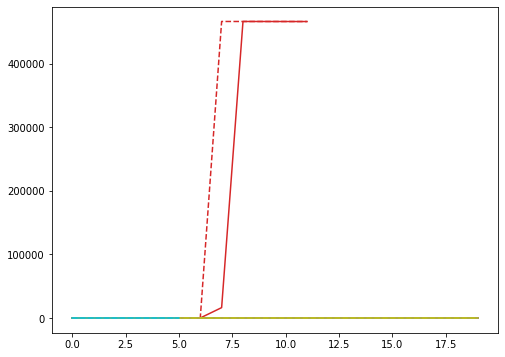

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9','tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()